# Model Training Assessment

Our data is not really meant for reinforcement learning. We have a single 12 band image and 1 label map for this image. The goal is to segment the image so it matches the label map, and then later we want to apply this algorithm to other multi-band images that do not have label maps. 

So the intention of our project is to optimize an unsupervised clustering algorithm (using deep learning), not apply reinforcement learning. Below, we did find some creative ways to apply reinforcement learning to our dataset, but it doesn't really fit the nature of our problem.

In [81]:
import numpy as np
import pandas as pd
import rioxarray as rxr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from skimage.transform import rescale, downscale_local_mean
from pycaret.classification import *

In [82]:
# Path to your working directory to store the images
data_path = "/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data/ai_ready/" # This is an example, change it to your own path

blendDEM = rxr.open_rasterio(data_path + "blendDEM_aiready.tif", cache=False)
blendSLOPE = rxr.open_rasterio(data_path + "blendSLOPE_aiready.tif", cache=False)

ctxDEM = rxr.open_rasterio(data_path + "ctxDEM_aiready.tif", cache=False)
ctxIMG = rxr.open_rasterio(data_path + "ctxIMG_aiready.tif", cache=False)
ctxSLOPE = rxr.open_rasterio(data_path + "ctxSLOPE_aiready.tif", cache=False)

dayIR = rxr.open_rasterio(data_path + "dayIR_aiready.tif", cache=False)
nightIR = rxr.open_rasterio(data_path + "nightIR_aiready.tif", cache=False)

hrscND = rxr.open_rasterio(data_path + "hrscND_aiready.tif", cache=False)
hrscP1 = rxr.open_rasterio(data_path + "hrscP1_aiready.tif", cache=False)
hrscP2 = rxr.open_rasterio(data_path + "hrscP2_aiready.tif", cache=False)
hrscS1 = rxr.open_rasterio(data_path + "hrscS1_aiready.tif", cache=False)
hrscS2 = rxr.open_rasterio(data_path + "hrscS2_aiready.tif", cache=False)

training_imgs = [blendDEM, blendSLOPE, ctxDEM, ctxIMG, ctxSLOPE, dayIR, nightIR, hrscND, hrscP1, hrscP2, hrscS1, hrscS2]
training_names = ['blendDEM', 'blendSLOPE', 'ctxDEM', 'ctxIMG', 'ctxSLOPE', 'dayIR', 'nightIR', 'hrscND', 'hrscP1', 'hrscP2', 'hrscS1', 'hrscS2']

label_map = rxr.open_rasterio("/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data/label/validation_map.tif", cache=False)

We have to downsample our image so that model training can be done in a reasonable amount of time.

In [83]:
# Downsample factor
downsample_factor = 0.1  # Adjust this factor based on the desired downsampling

# Function to downsample an image
def downsample_image(image, factor):
    return rescale(image.values[0], factor, anti_aliasing=True)

# Function to downsample a label map while maintaining discrete values
def downsample_label_map(label_map, factor):
    block_size = int(1 / factor)
    downsampled = downscale_local_mean(label_map.values[0], (block_size, block_size))
    return np.round(downsampled).astype(label_map.values.dtype)

# Downsample the images
subset_imgs = [blendDEM, blendSLOPE, ctxDEM, ctxIMG, ctxSLOPE, hrscND, hrscP1, hrscP2, hrscS1, hrscS2]
downsampled_imgs = [downsample_image(img, downsample_factor) for img in subset_imgs]

# Downsample the label map
downsampled_label_map = downsample_label_map(label_map, downsample_factor)

# Ensure the dimensions match by trimming the larger dimension
min_shape = (min(downsampled_label_map.shape[0], downsampled_imgs[0].shape[0]),
             min(downsampled_label_map.shape[1], downsampled_imgs[0].shape[1]))

downsampled_label_map = downsampled_label_map[:min_shape[0], :min_shape[1]]
downsampled_imgs = [img[:min_shape[0], :min_shape[1]] for img in downsampled_imgs]

# Combine the downsampled images into a multi-band image
downsampled_multi_band_image = np.stack(downsampled_imgs, axis=-1)

# Convert the downsampled images and label map back to xarray DataArray
# downsampled_imgs_xr = [rxr.DataArray(img, dims=("y", "x")) for img in downsampled_imgs]
# downsampled_label_map_xr = rxr.DataArray(downsampled_label_map, dims=("y", "x"))

print("Dimensions of downsampled_label_map:", downsampled_label_map.shape, downsampled_label_map.size)
print("Dimensions of downsampled_multi_band_image:", downsampled_multi_band_image.shape, downsampled_multi_band_image.size)

Dimensions of downsampled_label_map: (287, 305) 87535
Dimensions of downsampled_multi_band_image: (287, 305, 10) 875350


Split the data into training and test sets for cross validation.

In [84]:
# Flatten the multi-band image into a 2D array where each row represents a pixel and each column represents a band
pixels = downsampled_multi_band_image.reshape(-1, downsampled_multi_band_image.shape[-1])
labels = downsampled_label_map.ravel()

# Convert to a DataFrame
df = pd.DataFrame(pixels, columns=[f'band_{i+1}' for i in range(downsampled_multi_band_image.shape[-1])])
df['label'] = labels

# Remove pixels with no label (assuming no label is represented by a specific value, e.g., -1)
# df = df[df['label'] != -1]

# Split the data into training and testing sets
X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Dictionary to store accuracy results
accuracy_results = {}

# Manual Training techniques

Here is a sample of reinforcement learning done manually with scikit-learn.

## Random Forest

In [85]:
# Train and evaluate the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_results['Random Forest'] = accuracy_rf

# Support Vector Machine

In [86]:
# Train and evaluate the SVM classifier
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_results['SVM'] = accuracy_svm

## K-Nearest Neighbors

In [87]:
# Train and evaluate the KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_results['KNN'] = accuracy_knn

## Evaluate performance of different models

Random Forest Accuracy: 0.8318
SVM Accuracy: 0.5868
KNN Accuracy: 0.7741


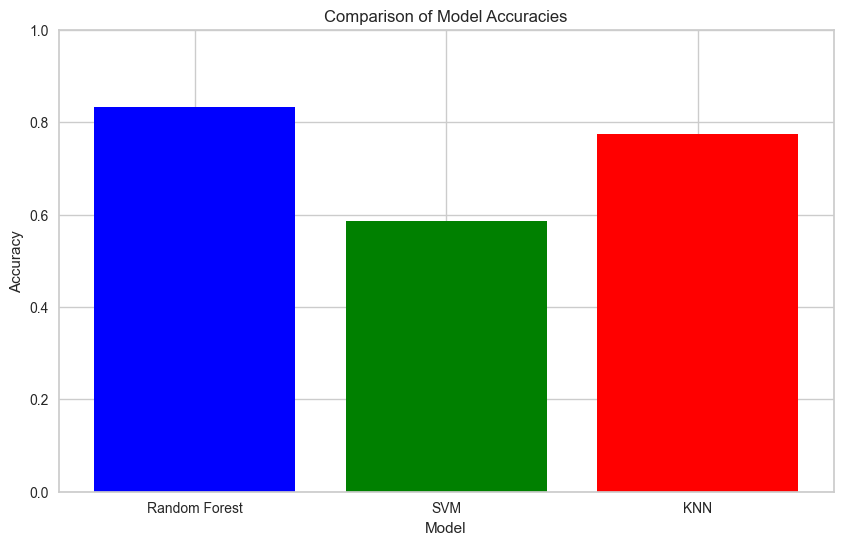

In [88]:
# Print accuracy results
for model, accuracy in accuracy_results.items():
    print(f'{model} Accuracy: {accuracy:.4f}')

# Plot the accuracy results
plt.figure(figsize=(10, 6))
plt.bar(accuracy_results.keys(), accuracy_results.values(), color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

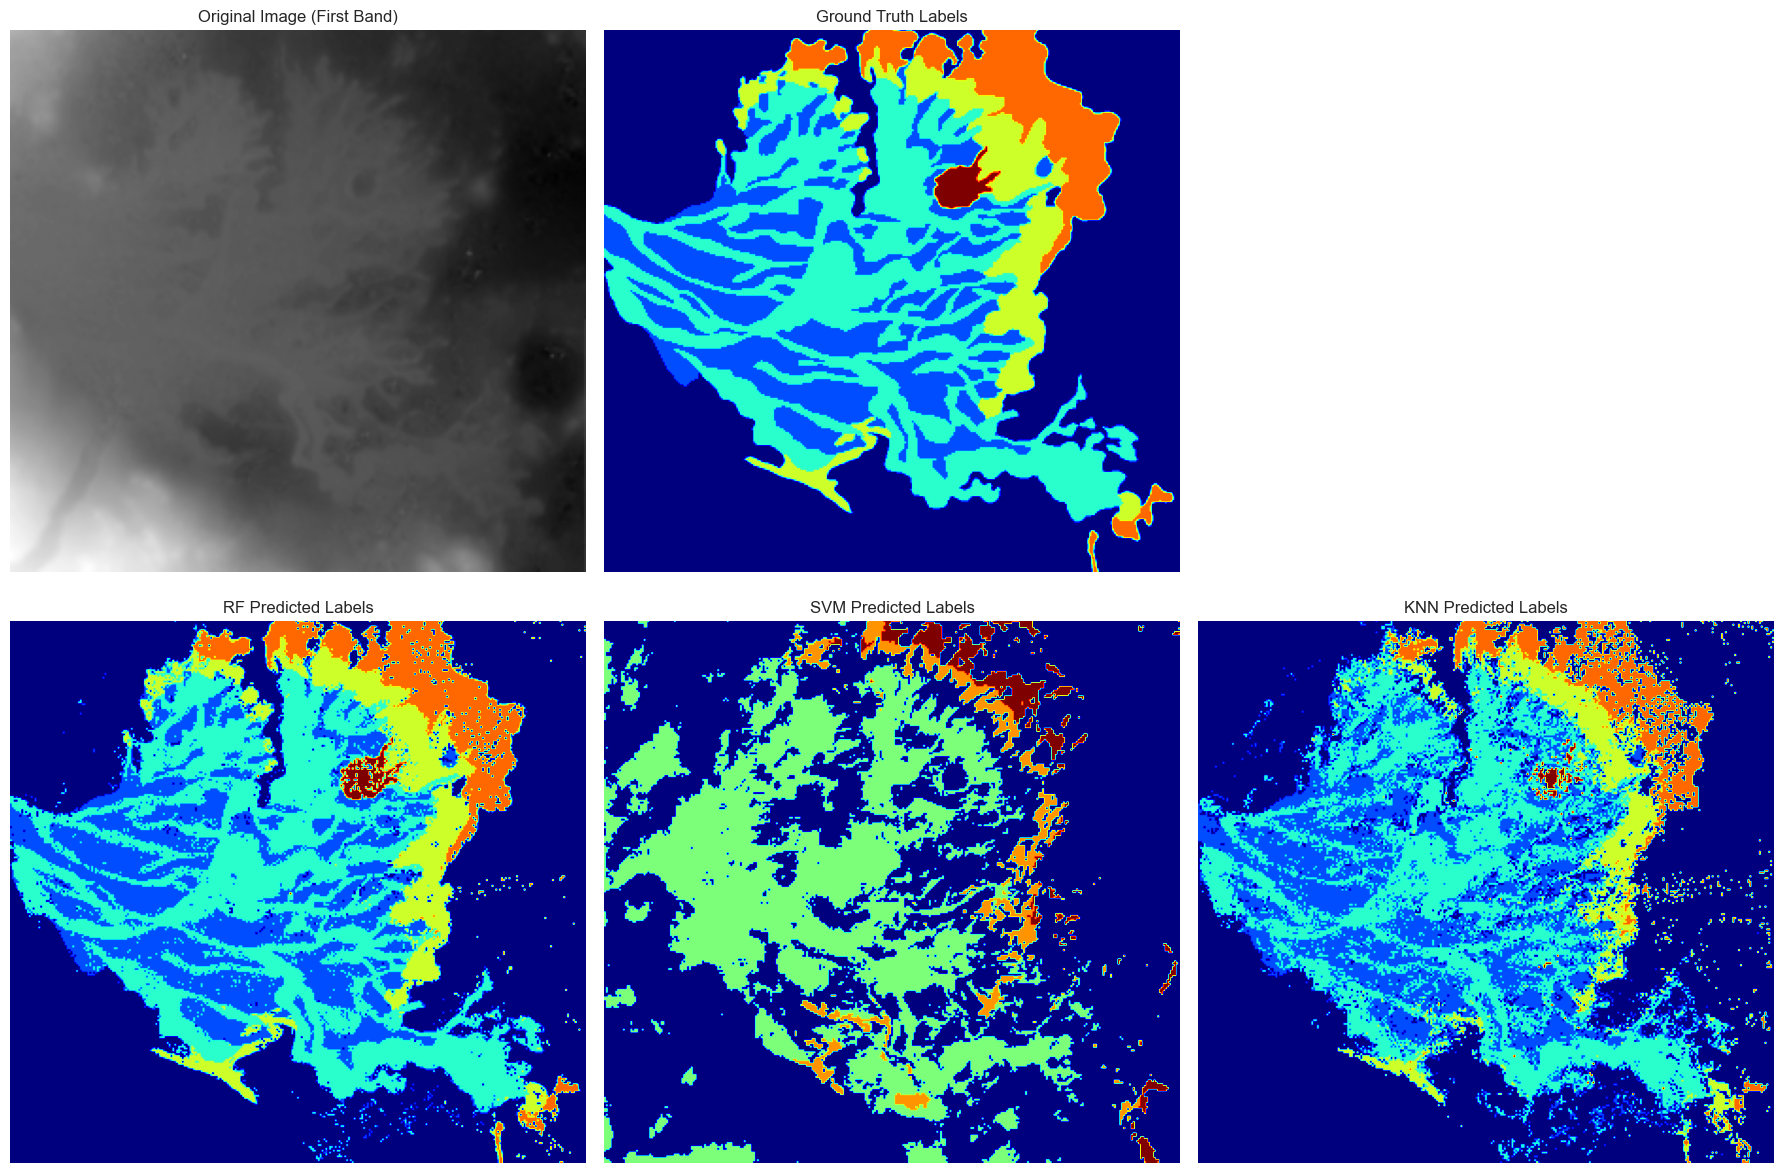

In [89]:
# Plot the original images, ground truth labels, and predicted labels
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Plot one of the original images (e.g., the first band)
axes[0].imshow(downsampled_imgs[2], cmap='gray')
axes[0].set_title('Original Image (First Band)')
axes[0].axis('off')

# Plot the ground truth labels
axes[1].imshow(downsampled_label_map, cmap='jet')
axes[1].set_title('Ground Truth Labels')
axes[1].axis('off')

axes[2].axis('off')

# Plot the predicted labels
# Predict on the entire downsampled multi-band image
predicted_labels = rf_model.predict(pixels)
predicted_label_map = predicted_labels.reshape(downsampled_label_map.shape)
axes[3].imshow(predicted_label_map, cmap='jet')
axes[3].set_title('RF Predicted Labels')
axes[3].axis('off')

predicted_labels = svm_model.predict(pixels)
predicted_label_map = predicted_labels.reshape(downsampled_label_map.shape)
axes[4].imshow(predicted_label_map, cmap='jet')
axes[4].set_title('SVM Predicted Labels')
axes[4].axis('off')

predicted_labels = knn_model.predict(pixels)
predicted_label_map = predicted_labels.reshape(downsampled_label_map.shape)
axes[5].imshow(predicted_label_map, cmap='jet')
axes[5].set_title('KNN Predicted Labels')
axes[5].axis('off')

plt.tight_layout()
plt.show()

So it looks like SVM is doing a bad job of recognizing the label maps. RF is overfit to the labels. KNN is probably the best since it isn't as overfit as RF and does a decent job of recreating the label maps.

# Training with PyCaret

Now we do another reinforcement learning analysis but with PyCaret to optimize the training process and get learning curves with other metrics.

In [90]:
s = setup(data=df, target='label')
best = compare_models()

,Description,Value
0,Session id,8792
1,Target,label
2,Target type,Multiclass
3,Original data shape,"(87535, 11)"
4,Transformed data shape,"(87535, 11)"
5,Transformed train set shape,"(61274, 11)"
6,Transformed test set shape,"(26261, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8295,0.9675,0.8295,0.8292,0.8264,0.7493,0.7501,0.7140
rf,Random Forest Classifier,0.8239,0.9654,0.8239,0.8230,0.8210,0.7413,0.7419,1.9100
lightgbm,Light Gradient Boosting Machine,0.7942,0.9562,0.7942,0.7932,0.7929,0.6994,0.6997,4.2310
knn,K Neighbors Classifier,0.7692,0.9292,0.7692,0.7650,0.7650,0.6598,0.6605,0.0780
dt,Decision Tree Classifier,0.7535,0.8335,0.7535,0.7540,0.7537,0.6425,0.6426,0.1150
gbc,Gradient Boosting Classifier,0.7313,0.0000,0.7313,0.7292,0.7266,0.6045,0.6059,14.5750
qda,Quadratic Discriminant Analysis,0.6511,0.0000,0.6511,0.6766,0.6590,0.5093,0.5123,0.0160
nb,Naive Bayes,0.5954,0.8579,0.5954,0.6470,0.6133,0.4422,0.4465,0.0130
lda,Linear Discriminant Analysis,0.5688,0.0000,0.5688,0.5290,0.5281,0.3228,0.3354,0.0150
lr,Logistic Regression,0.5660,0.0000,0.5660,0.5297,0.5225,0.3144,0.3283,0.4020


The extra trees classifier has the highest accuracy, with the random forest in close second. This is interesting considering the earlier analysis in this notebook because it suggests the ET and RF models are overfit. Unfortunately we don't have other images to test this on and see if that is true.

In [91]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

ROC curves look typical for Extra Trees and would actually suggest it is doing a very good job. 

In [92]:
pred_holdout = predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8400,0.9703,0.8400,0.8394,0.8373,0.7649,0.7656


Do a prediction test for additional robustness.

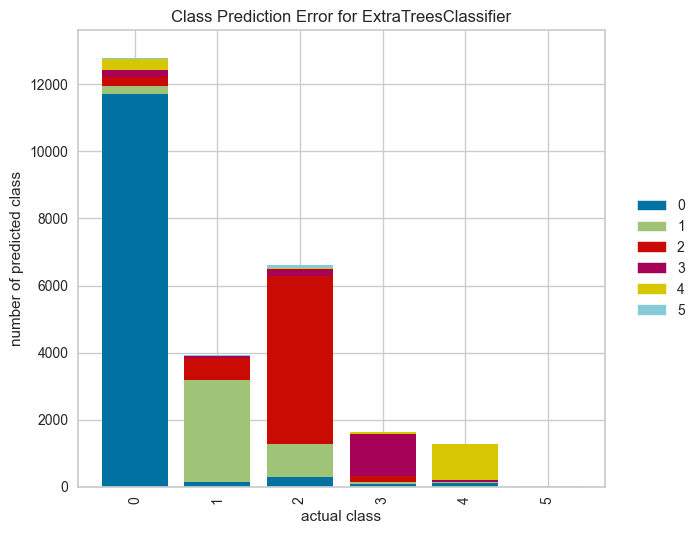

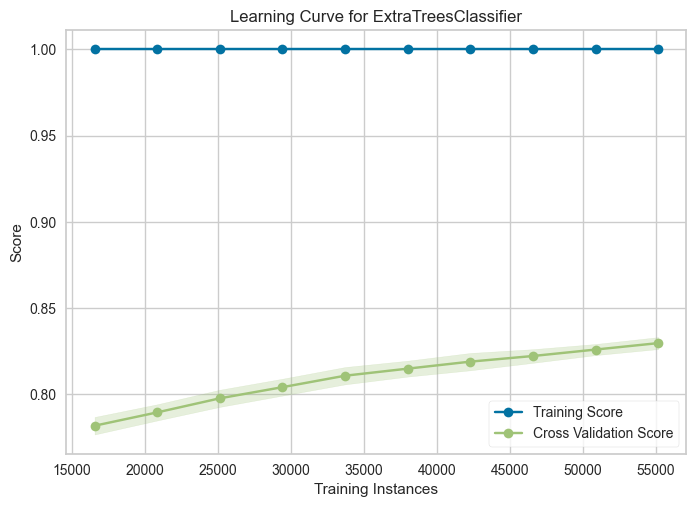

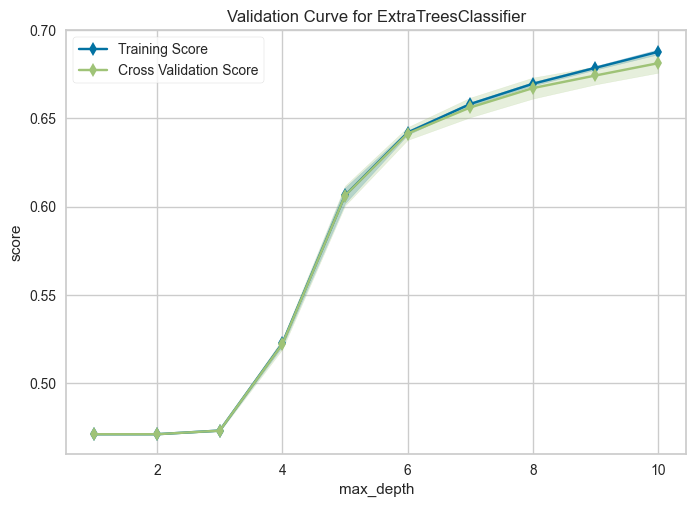

In [96]:
# Plot cross-validation diagnostics for the best model
# Residuals Plot

# Error Plot
plot_model(best, plot='error')

# Learning Curve
plot_model(best, plot='learning')

# Validation Curve
plot_model(best, plot='vc')